# TP 2-3 : Branch-and-bound applied to a knapsack problem

### Initialisation (à faire une seule fois)

In [1]:
import Pkg; 
Pkg.add("GraphRecipes"); Pkg.add("Plots"); 
using GraphRecipes, Plots #only used to visualize the search tree at the end of the branch-and-bound

    Updating registry at `C:\Users\zenon\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `C:\Users\zenon\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\zenon\.julia\environments\v1.6\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\zenon\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\zenon\.julia\environments\v1.6\Manifest.toml`


### Lecture des données

In [2]:
function readKnaptxtInstance(filename)
    price=[]
    weight=[]
    KnapCap=[]
    open(filename) do f
        for i in 1:3
            tok = split(readline(f))
            if(tok[1] == "ListPrices=")
                for i in 2:(length(tok)-1)
                    push!(price,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "ListWeights=")
                for i in 2:(length(tok)-1)
                    push!(weight,parse(Int64, tok[i]))
                end
            elseif(tok[1] == "Capacity=")
                push!(KnapCap, parse(Int64, tok[2]))
            else
                println("Unknown read :", tok)
            end 
        end
    end
    capacity=KnapCap[1]
    return price, weight, capacity
end

readKnaptxtInstance (generic function with 1 method)

### Tests de sondabilités TA, TO et TR pour le cas de la relaxation linéaire

In [3]:
function TestsSondabilite_relaxlin(BestProfit, Bestsol, varsshouldbebinary, infeasible, objective::Function)
    TA, TO, TR = false, false, false # Initialisation des variables de sortie
    roundbin = zeros(length(varsshouldbebinary)) # variable intermédiaire pour comparer si la solution est binaire (0 ou 1)
    diffabs = zeros(length(varsshouldbebinary)) # différence entre la variable intermédiaire et la solution
    
    #Initialisation des vars intermédiaires
    for i in 1:length(varsshouldbebinary)
        roundbin[i] = round(varsshouldbebinary[i], digits = 0)
        diffabs[i] = abs(roundbin[i]-varsshouldbebinary[i])
    end
    
   if(infeasible)#Test de faisabilite
        TA=true
        println("TA")
    elseif(objective(varsshouldbebinary) <= BestProfit) # Test d'optimalité
        TO=true
        println("TO")
    elseif sum(diffabs) <= 10^-5 #Test de resolution
        TR=true
        println("TR")
        # Si variables binaires on met à jour la (meilleure) solution et le (meilleur) profit retenu
        if (objective(varsshouldbebinary) >= BestProfit)
            Bestsol = varsshouldbebinary
            BestProfit = objective(varsshouldbebinary)
        end
    else
        println("non sondable")
    end
    TA, TO, TR, Bestsol, BestProfit
end


TestsSondabilite_relaxlin (generic function with 1 method)

### Procédure de séparation

In [4]:
function SeparerNoeud_relaxlin(varsshouldbebinary, listvars, listvals)
    # le noeud est non-sondable. Appliquer le critère de séparation pour le séparer en sous-noeuds 
    # et choisir un noeud-fils le plus à gauche   
    
    #find a fractionnal variable
    i, var = 1, 0
    while((i <= length(varsshouldbebinary)) && (var==0))
        #if(varsshouldbebinary[i] ∉ listvars)
        if(abs(round(varsshouldbebinary[i], digits=0) - varsshouldbebinary[i] ) >= 10^-5)
            var=i # On renvoie l'indice de la variable fractionnaire on séparera ce noeud sur cette variable
        end
        i+=1
    end
    
    push!(listvars,var) #stocker l'identite de la variable choisie pour la séparation
    push!(listvals,1.0) #stocker la branche choisie, identifiee par la valeur de la variable choisie
    listvars, listvals
end


SeparerNoeud_relaxlin (generic function with 1 method)

### Stratégie d'exploration

In [5]:
function ExplorerAutreNoeud_relaxlin(listvars, listvals, listnodes)
    #this node is sondable, go back to parent node then right child if possible
    
    stop=false
    #check if we are not at the root node
    if (length(listvars)>= 1)
        #go back to parent node
        var=pop!(listvars)
        theval=pop!(listvals)
        tmp=pop!(listnodes)


        #go to right child if possible, otherwise go back to parent
        while( (theval==0.0) && (length(listvars)>= 1))
            var=pop!(listvars)
            theval=pop!(listvals)
            tmp=pop!(listnodes)

        end
        if theval==1.0
            push!(listvars,var)
            push!(listvals,0.0)
        else
            println("\nFINISHED")
            stop=true
        end
    else
        #the root node was sondable
        println("\nFINISHED")
        stop=true
    end
    listvars, listvals, listnodes, stop 
end

ExplorerAutreNoeud_relaxlin (generic function with 1 method)

### Relaxation Linéaire

In [6]:
function CalculerBorne_relaxlin(ratio_index,listvars,listvals,price,weight,capacity)
    # initialisation des variables
    borne = 0 # borne supérieure
    capacite = capacity # capacité initiale
    infeasible = false # booléen du test d'admissibilité
    varsshouldbebinary = zeros(length(price)) # intialisation du vecteur solution 
    i = 1 # indice initiale pour parcourir nos vecteur dans la dernière boucle
    
    # On reprend les anciennes valeurs sur lesquels on s'est mis d'accord dans ce noeud
    for i in 1:length(listvars)
        index = listvars[i]
        varsshouldbebinary[index] = listvals[i]
        borne = borne + listvals[i]*price[index]
        capacite = capacite -listvals[i]*weight[index]
    end
    
    # Test d'admissibilité
    if(capacite<0.0)
        infeasible = true
    end
    
    # On essaie de remplir le sac avec de nouveaux objets
    while(capacite>0.0 && i <= length(price))
        index = ratio_index[i]
        if !(index in listvars)
            if((capacite - weight[index])>=0)
                borne = borne + price[index]
                varsshouldbebinary[index] = 1.0
                capacite = capacite - weight[index]
            else
                borne = borne + (capacite/weight[index])*price[index]
                varsshouldbebinary[index] = (capacite/weight[index]) # Si on déborde capacite/weight[i] = 0 car capacite sera nulle
                capacite = capacite - (capacite/weight[index])*weight[index] # égal à 0 si (la capacité moins le poids de l'indice) est négative
            end
        end
        i = i +1 # mise à jour de l'indice d'itération
    end
    return infeasible,varsshouldbebinary,borne
end

CalculerBorne_relaxlin (generic function with 1 method)

### Boucle principale : résoudre la relaxation linéaire, appliquer les tests de sondabilité, identifier le prochain noeud, répéter.

In [7]:
function SolveKnapInstance(filename)
    # Initialisation (Création du Modèle)
    price, weight, capacity = readKnaptxtInstance(filename)
    n = length(price) # dimension des vecteurs
    ratio = price./weight # ratio prix/poids
    ratio_index = sortperm(ratio, rev = true) # indices des ratios triés du plus grand au plus petit
    varsshouldbebinary = zeros(n) # vecteur solution initialisé à 0
        
    # fonction objectif
    function objective(x)
        return sum(x.*price)
    end
    
    #create the structure to memorize the search tree for visualization at the end
    trParentnodes=Int64[] #will store orig node of arc in search tree
    trChildnodes=Int64[] #will store destination node of arc in search tree
    trNamenodes=[] #will store names of nodes in search tree
        
    #intermediate structure to navigate in the search tree
    listvars=[]
    listvals=[]
    listnodes=[]

    BestProfit=-1
    Bestsol=[]

    current_node_number=0
    stop = false

    while (!stop)

        #Update the search tree
        push!(trNamenodes,current_node_number+1) 
        if (length(trNamenodes)>=2)
            push!(trParentnodes,listnodes[end]+1) # +1 because the 1st node is "node 0"
            push!(trChildnodes, current_node_number+1) # +1 because the 1st node is "node 0"
        end
        push!(listnodes, current_node_number)
        
        # Calcul de la borne supérieur et mise à jour du vecteur solution
        infeasible,varsshouldbebinary,borne = CalculerBorne_relaxlin(ratio_index,listvars,listvals,price,weight,capacity)
            
        # Réalisation des tests de sondabilité
        TA, TO, TR, Bestsol, BestProfit =  TestsSondabilite_relaxlin(BestProfit, Bestsol, varsshouldbebinary, infeasible, objective)
            
        is_node_sondable = TA || TO || TR
        # Si le noeud n'est pas sondable :
        if (!is_node_sondable)
            # On sépare le noeud en 2 sous noeuds
            listvars, listvals = SeparerNoeud_relaxlin(varsshouldbebinary, listvars, listvals)
        else
            # Sinon : 
            # On explore les autres noeuds à disposition
            listvars, listvals, listnodes, stop = ExplorerAutreNoeud_relaxlin(listvars, listvals, listnodes)
        end
        
        # Mise à jour du numéro du noeud actuel (on s'en sert pour afficher le graphe)
        current_node_number = current_node_number + 1
    end
    
    return BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes
end


SolveKnapInstance (generic function with 1 method)

### Affichage du résultat final

non sondable
non sondable
TA
non sondable
TA
TR
non sondable
non sondable
non sondable
TA
TO
TO
TR

FINISHED

******

Optimal value = 65.0

Optimal x=[0.0, 1.0, 0.0, 1.0]


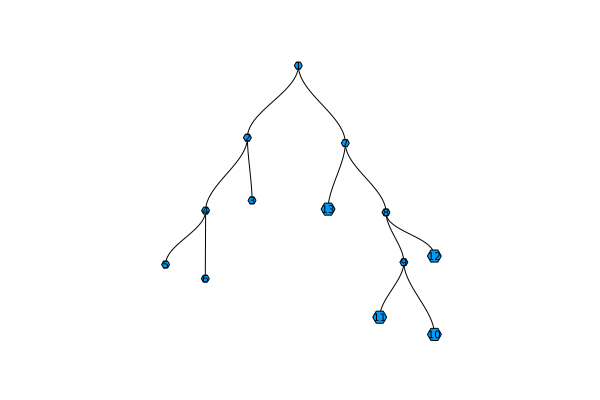

In [8]:
filename = "../instancesETU/KNAPnewformat/test.opb.txt"
BestProfit, Bestsol, trParentnodes, trChildnodes, trNamenodes = SolveKnapInstance(filename)
println("\n******\n\nOptimal value = ", BestProfit, "\n\nOptimal x=", Bestsol)
graphplot(trParentnodes, trChildnodes, names=trNamenodes, method=:tree)